In [2]:
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
#Step1 Get Original Data from Interactivebroker
filename = "SPY_20040123_20200529_30min.csv" #from IB
df = pd.read_csv(filename,index_col = 0)
# df.reset_index(drop=True,inplace=True)
print(df.shape)
print(df.head(1))
print(df.tail(1))

(54688, 7)
                        open     high      low    close  volume  average  \
date                                                                       
2004-01-23 08:30:00  115.015  115.155  114.895  115.005      -1     -1.0   

                     barCount  
date                           
2004-01-23 08:30:00        -1  
                       open    high      low    close  volume  average  \
date                                                                     
2020-05-29 14:30:00  303.63  304.96  303.315  304.025      -1     -1.0   

                     barCount  
date                           
2020-05-29 14:30:00        -1  


False


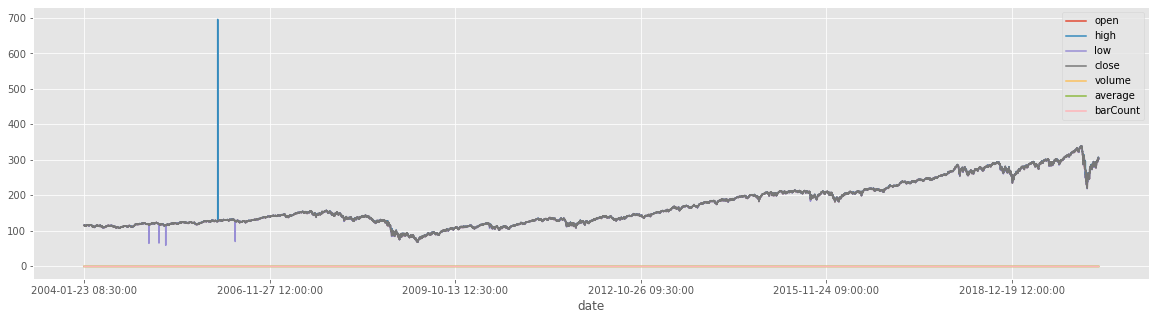

In [4]:
#Step2 check data

#Check NAN
print(df.isnull().values.any() )

#check Outlier
plt.style.use("ggplot")
plt.rcParams["figure.figsize"]=(20,5)
df.plot()

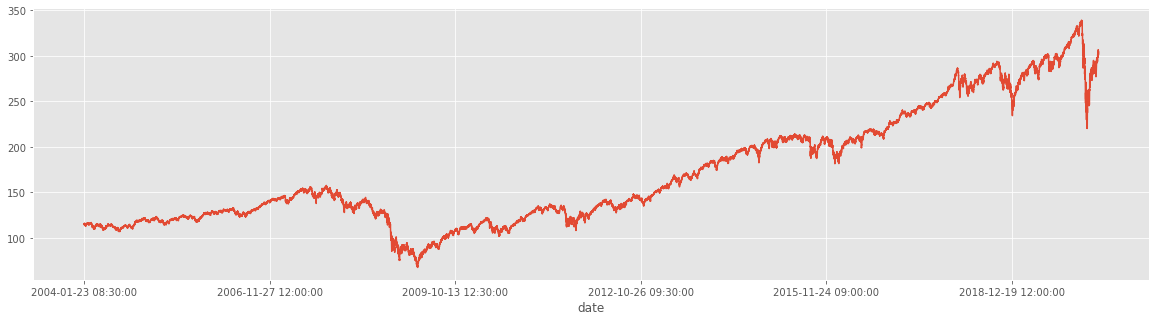

In [5]:
#Step Clean Data
tc=df.#targetclose
tc.plot()

In [8]:
profit1 =  tc.shift(-2) / tc.shift(-1)
profit5 =  tc.shift(-6) / tc.shift(-1)
profit10 = tc.shift(-11) / tc.shift(-1)
profit60 = tc.shift(-61) / tc.shift(-1)

print(type(profit1),profit1[:5])

<class 'pandas.core.series.Series'> date
2004-01-23 08:30:00    0.997138
2004-01-23 09:00:00    0.999130
2004-01-23 09:30:00    1.000958
2004-01-23 10:00:00    0.997695
2004-01-23 10:30:00    0.998692
Name: close, dtype: float64


In [13]:
!pip install TA-Lib

  ERROR: Command errored out with exit status 1:
   command: 'C:\Users\avlel\anaconda3\envs\OM8MO\python.exe' -u -c 'import sys, setuptools, tokenize; sys.argv[0] = '"'"'C:\\Users\\avlel\\AppData\\Local\\Temp\\pip-install-zv5_ewj7\\TA-Lib\\setup.py'"'"'; __file__='"'"'C:\\Users\\avlel\\AppData\\Local\\Temp\\pip-install-zv5_ewj7\\TA-Lib\\setup.py'"'"';f=getattr(tokenize, '"'"'open'"'"', open)(__file__);code=f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' bdist_wheel -d 'C:\Users\avlel\AppData\Local\Temp\pip-wheel-isohyw0k'
       cwd: C:\Users\avlel\AppData\Local\Temp\pip-install-zv5_ewj7\TA-Lib\
  Complete output (20 lines):
  C:\Users\avlel\AppData\Local\Temp\pip-install-zv5_ewj7\TA-Lib\setup.py:79: UserWarning: Cannot find ta-lib library, installation may fail.
    warnings.warn('Cannot find ta-lib library, installation may fail.')
  running bdist_wheel
  running build
  running build_py
  creating build
  creating build\lib.win


  Running setup.py clean for TA-Lib
Failed to build TA-Lib
    Running setup.py install for TA-Lib: started
    Running setup.py install for TA-Lib: finished with status 'error'


In [16]:
import talib

ModuleNotFoundError: No module named 'talib'

In [15]:

df = tc.talib('CDL2CROWS')
# df = df.unstack()

profit10[df < 0].mean()

AttributeError: 'Series' object has no attribute 'talib'

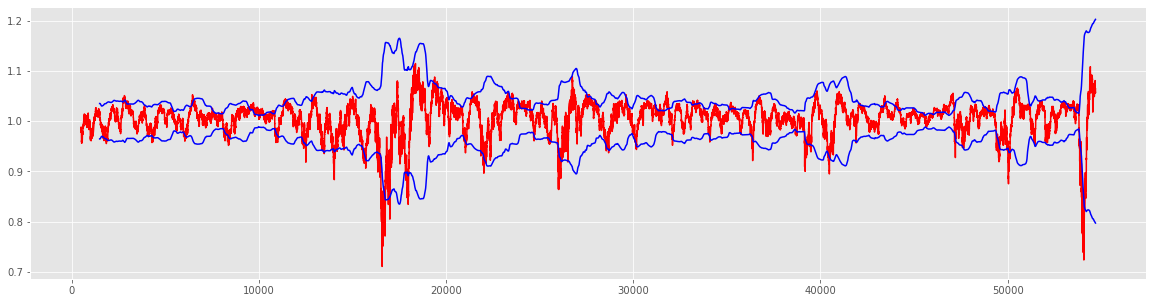

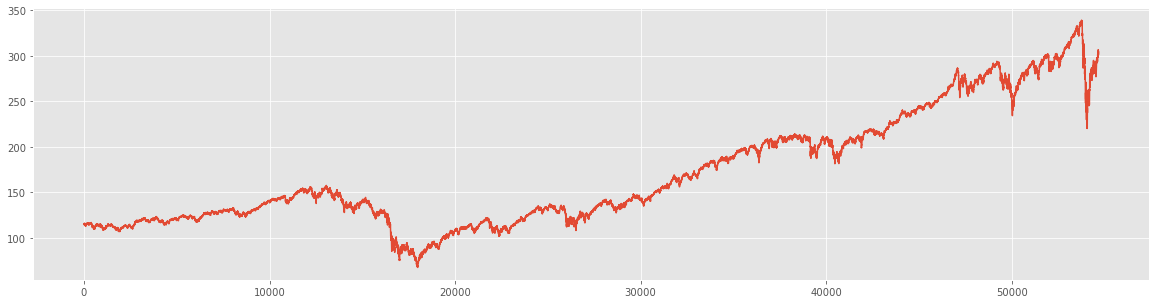

In [16]:
#Step4 MA Strategy
n_bars = 500
n_up_bars=1000
n_dn_bars=1000

sma = tc.rolling(n_bars).mean()
bias = tc / sma
ub =1+ bias.rolling(n_up_bars).std() * 2
lb = 1 - bias.rolling(n_dn_bars).std() * 2

import matplotlib.pyplot as plt

plt.plot(bias.values,c='red')
plt.plot(ub.values,c='blue')
plt.plot(lb.values,c='blue')

plt.show()
plt.plot(tc.values)

<class 'pandas.core.series.Series'>
transaction times: 530


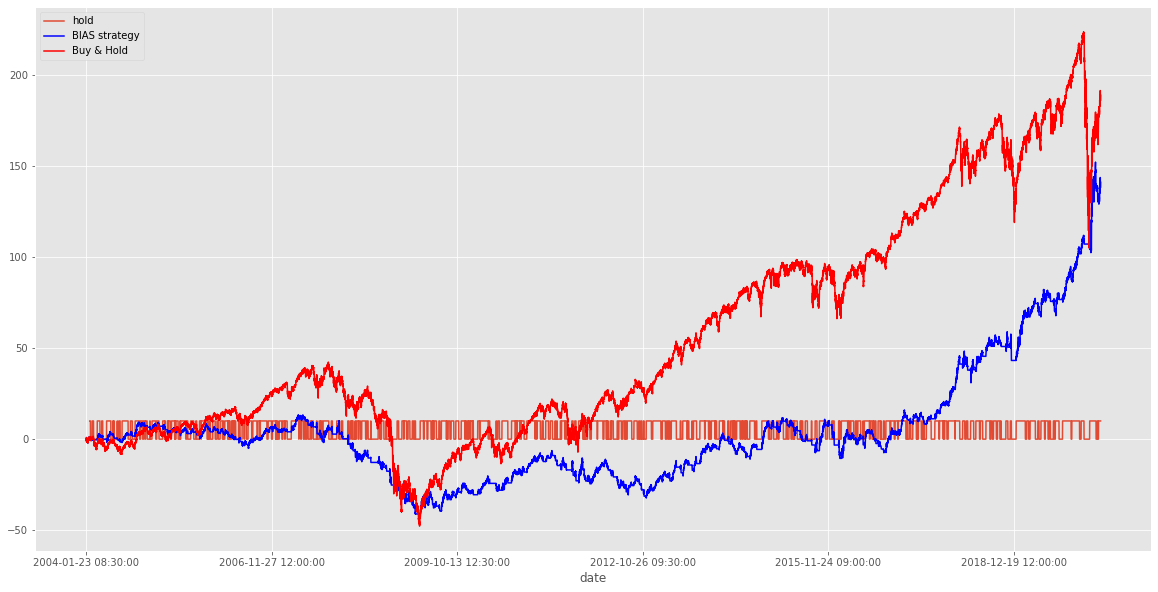

141.19999999999982

In [52]:
import numpy as np
import pandas as pd
%matplotlib inline
print(type(tc))
def strategy(tc,n_bars=100, n_side_bars=100, std_times=1, draw_plot=""):
    
    sma = tc.rolling(n_bars).mean()

    bias = (tc / sma)
    ub = 1 + bias.rolling(n_side_bars).std() * std_times
    lb = 1 - bias.rolling(n_side_bars).std() * std_times
    
    buy = (bias < lb) 
    sell = (bias > ub)

    hold = pd.Series(np.nan, index=sell.index)
    hold[buy] = 0
    hold[sell] = 1
    hold = hold.ffill()

    #prc type
    #No Delay 
    #BuyandHold
    return_prc = tc.shift(-1)/tc
    bh_prc = return_prc.cumprod()
    #buy with Signal
    return_prc[hold==0]=1

#     retprc -= hold.diff().abs()*(0.0005)
    creturn_prc = return_prc.cumprod()
    
    if draw_plot=="prc":
        print("transaction times:", np.count_nonzero(hold.diff().abs()==1))
        plt.rcParams["figure.figsize"] = (20,10)
        plt.plot(bh_prc, c='blue',label="Buy & Hold")
        plt.plot(creturn_prc,c="red", label="Bias")
        plt.legend(loc='best')
        plt.show()
    ######################################################################
    #Gap type
    #No Delay 
#     returns = twii.shift(-2) - twii.shift(-1)
    returns = tc.shift(-1)-tc
    returns[hold == 0] = 0
    #No Cost
#     returns -= hold.diff().abs() * 3
    creturn = returns.cumsum()
    
    
    if draw_plot=="gap":
        print("transaction times:", np.count_nonzero(hold.diff().abs()==1))
        plt.rcParams["figure.figsize"] = (20,10)
        (hold*10).plot(label="hold")
        creturn.plot(c="blue", label="BIAS strategy")
        (tc-tc[0]).plot(c="red", label="Buy & Hold")
        plt.legend(loc='best')
        plt.show()
     
    return creturn.dropna()[-1]

    
strategy(tc,draw_plot="gap")
# strategy(tc[1000:2000],draw_plot="prc")

In [62]:
#Optimizatino
vmax = 0
for m1 in range(5, 100, 5):
    for m2 in range(5, 100, 5):
        v = strategy(tc,m1, m2, 1)
        if v > vmax:
            vmax = v
            print(vmax, m1, m2, 1)
print("-------------------")
print(vmax, m1, m2, 1)

120.09000000000009 5 5 1
170.98999999999998 5 10 1
177.24999999999946 5 85 1
187.84499999999977 15 5 1
197.61499999999938 15 10 1
201.9099999999998 20 5 1
-------------------
201.9099999999998 95 95 1


transaction times: 2841


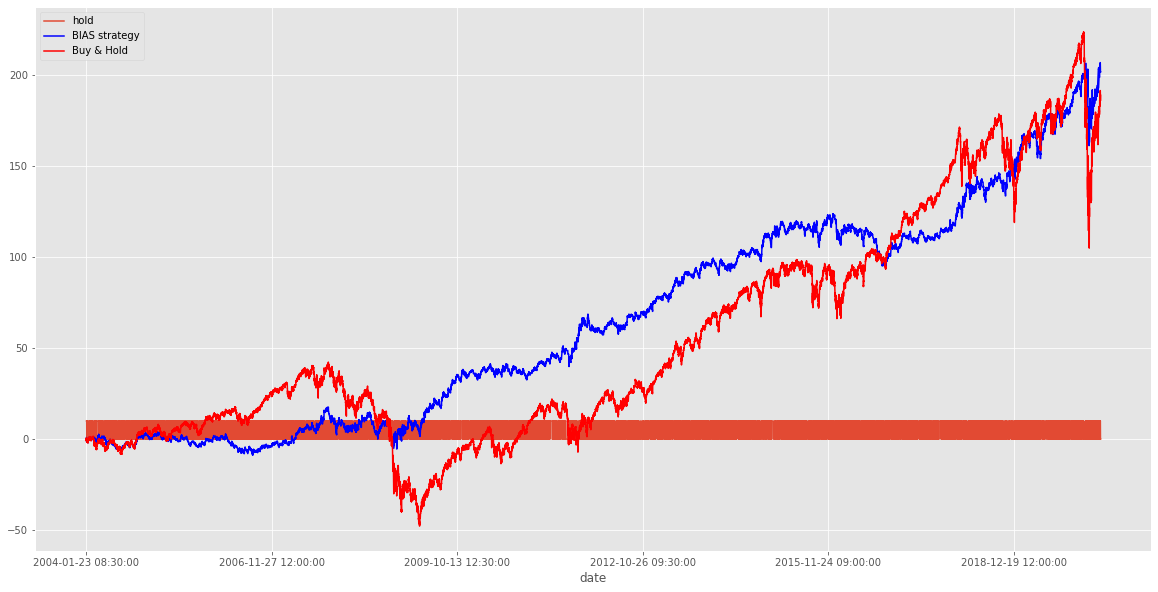

201.9099999999998

In [63]:
strategy(tc,20, 5, 1, "gap")

transaction times: 9


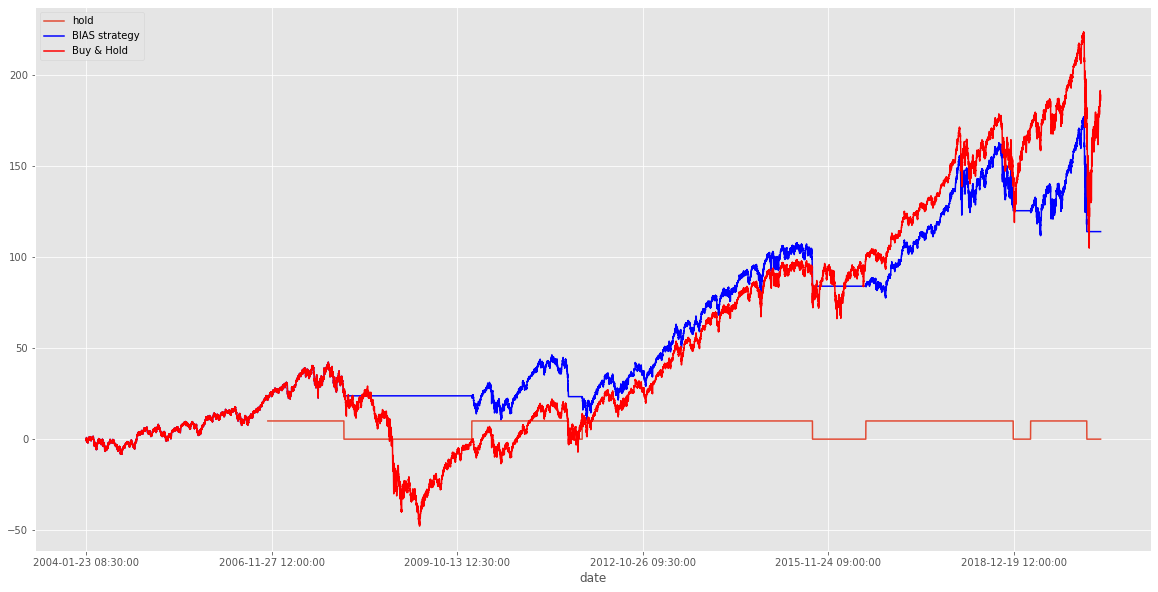

114.07999999999998

In [54]:
strategy(tc,20, 5, 1, "gap")

In [ ]:
strategy(tc,20, 5, 1, "prc")

transaction times: 2841
